# Marine Heatwaves Definition

We are using the marine heatwave (MHW) detection algorithm written by Eric Oliver and published by Hobday et al. 2016 to derive MHW statistics for the Northwest Atlantic continental shelf.  
  
The code is applied to daily OISST data.

In [1]:
# Load required modules
import numpy as np
import xarray as xr
from datetime import date
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from datetime import datetime
import matplotlib.dates as mdates


# Load marineHeatWaves definition module
import marineHeatWaves as mhw

# %pylab inline

# Load SST data

In [2]:
# load oisst as test

# oisst = xr.open_dataset('/vortex/clidex/data/obs/OISST/OISSTv2.1/sst.day.mean_1982.01-2019.12.nc')
# # change lon from 0-360 to -180-180
# oisst = oisst.sel(lon=slice(-80+360,-50+360),lat=slice(35,60))
# lon = oisst['lon'].values
# lon[lon>180] = lon[lon>180]-360
# oisst['lon'] = lon

# check that we cut out correct box
# oisst['sst'][0,::].plot()

# save file for repeated use
# oisst.to_netcdf('./data/oisst_nwa.nc')
oisst = xr.open_dataset('./data/oisst_nwa.nc')

# Load masks for eco regions

In [3]:
# eco = xr.open_dataset('/home/sryan/Python/ORCA/NW_Atlantic/Ecoregions_NEMO_mask_Hendrik.nc')

mask_names = ['Southern MAB','Northern MAB','Georges Bank','Western GoM',
             'Eastern GoM','Western SS','Eastern SS','Southern GSL','Northern GSL',
             'NFL Shelf','Northern NFL Shelf','Labrador Shelf1', 'Labrador Shelf2',
             'Labrador Shelf3','A','B','C','D','E','F','G','H']

# # interpolate masks on OISST grid
# [xm,ym] = np.meshgrid(oisst.lon,oisst.lat,indexing='ij')
# mask = xr.ones_like(oisst.isel(time=0)).drop('sst')
# for i in range(22):
#     dummy = griddata((eco['nav_lon'].values.ravel(),eco['nav_lat'].values.ravel()),
#                     eco['mask'][i,::].values.ravel(), (xm, ym),'nearest')
#     dummy[dummy==1]=np.nan
#     dummy[dummy==0]=1
#     mask[mask_names[i]] = (('lon','lat'),dummy)

# save regridded mask
# mask.to_netcdf('./data/ecomasks_oisst_nwa.nc')
mask = xr.open_dataset('./data/ecomasks_oisst_nwa.nc')

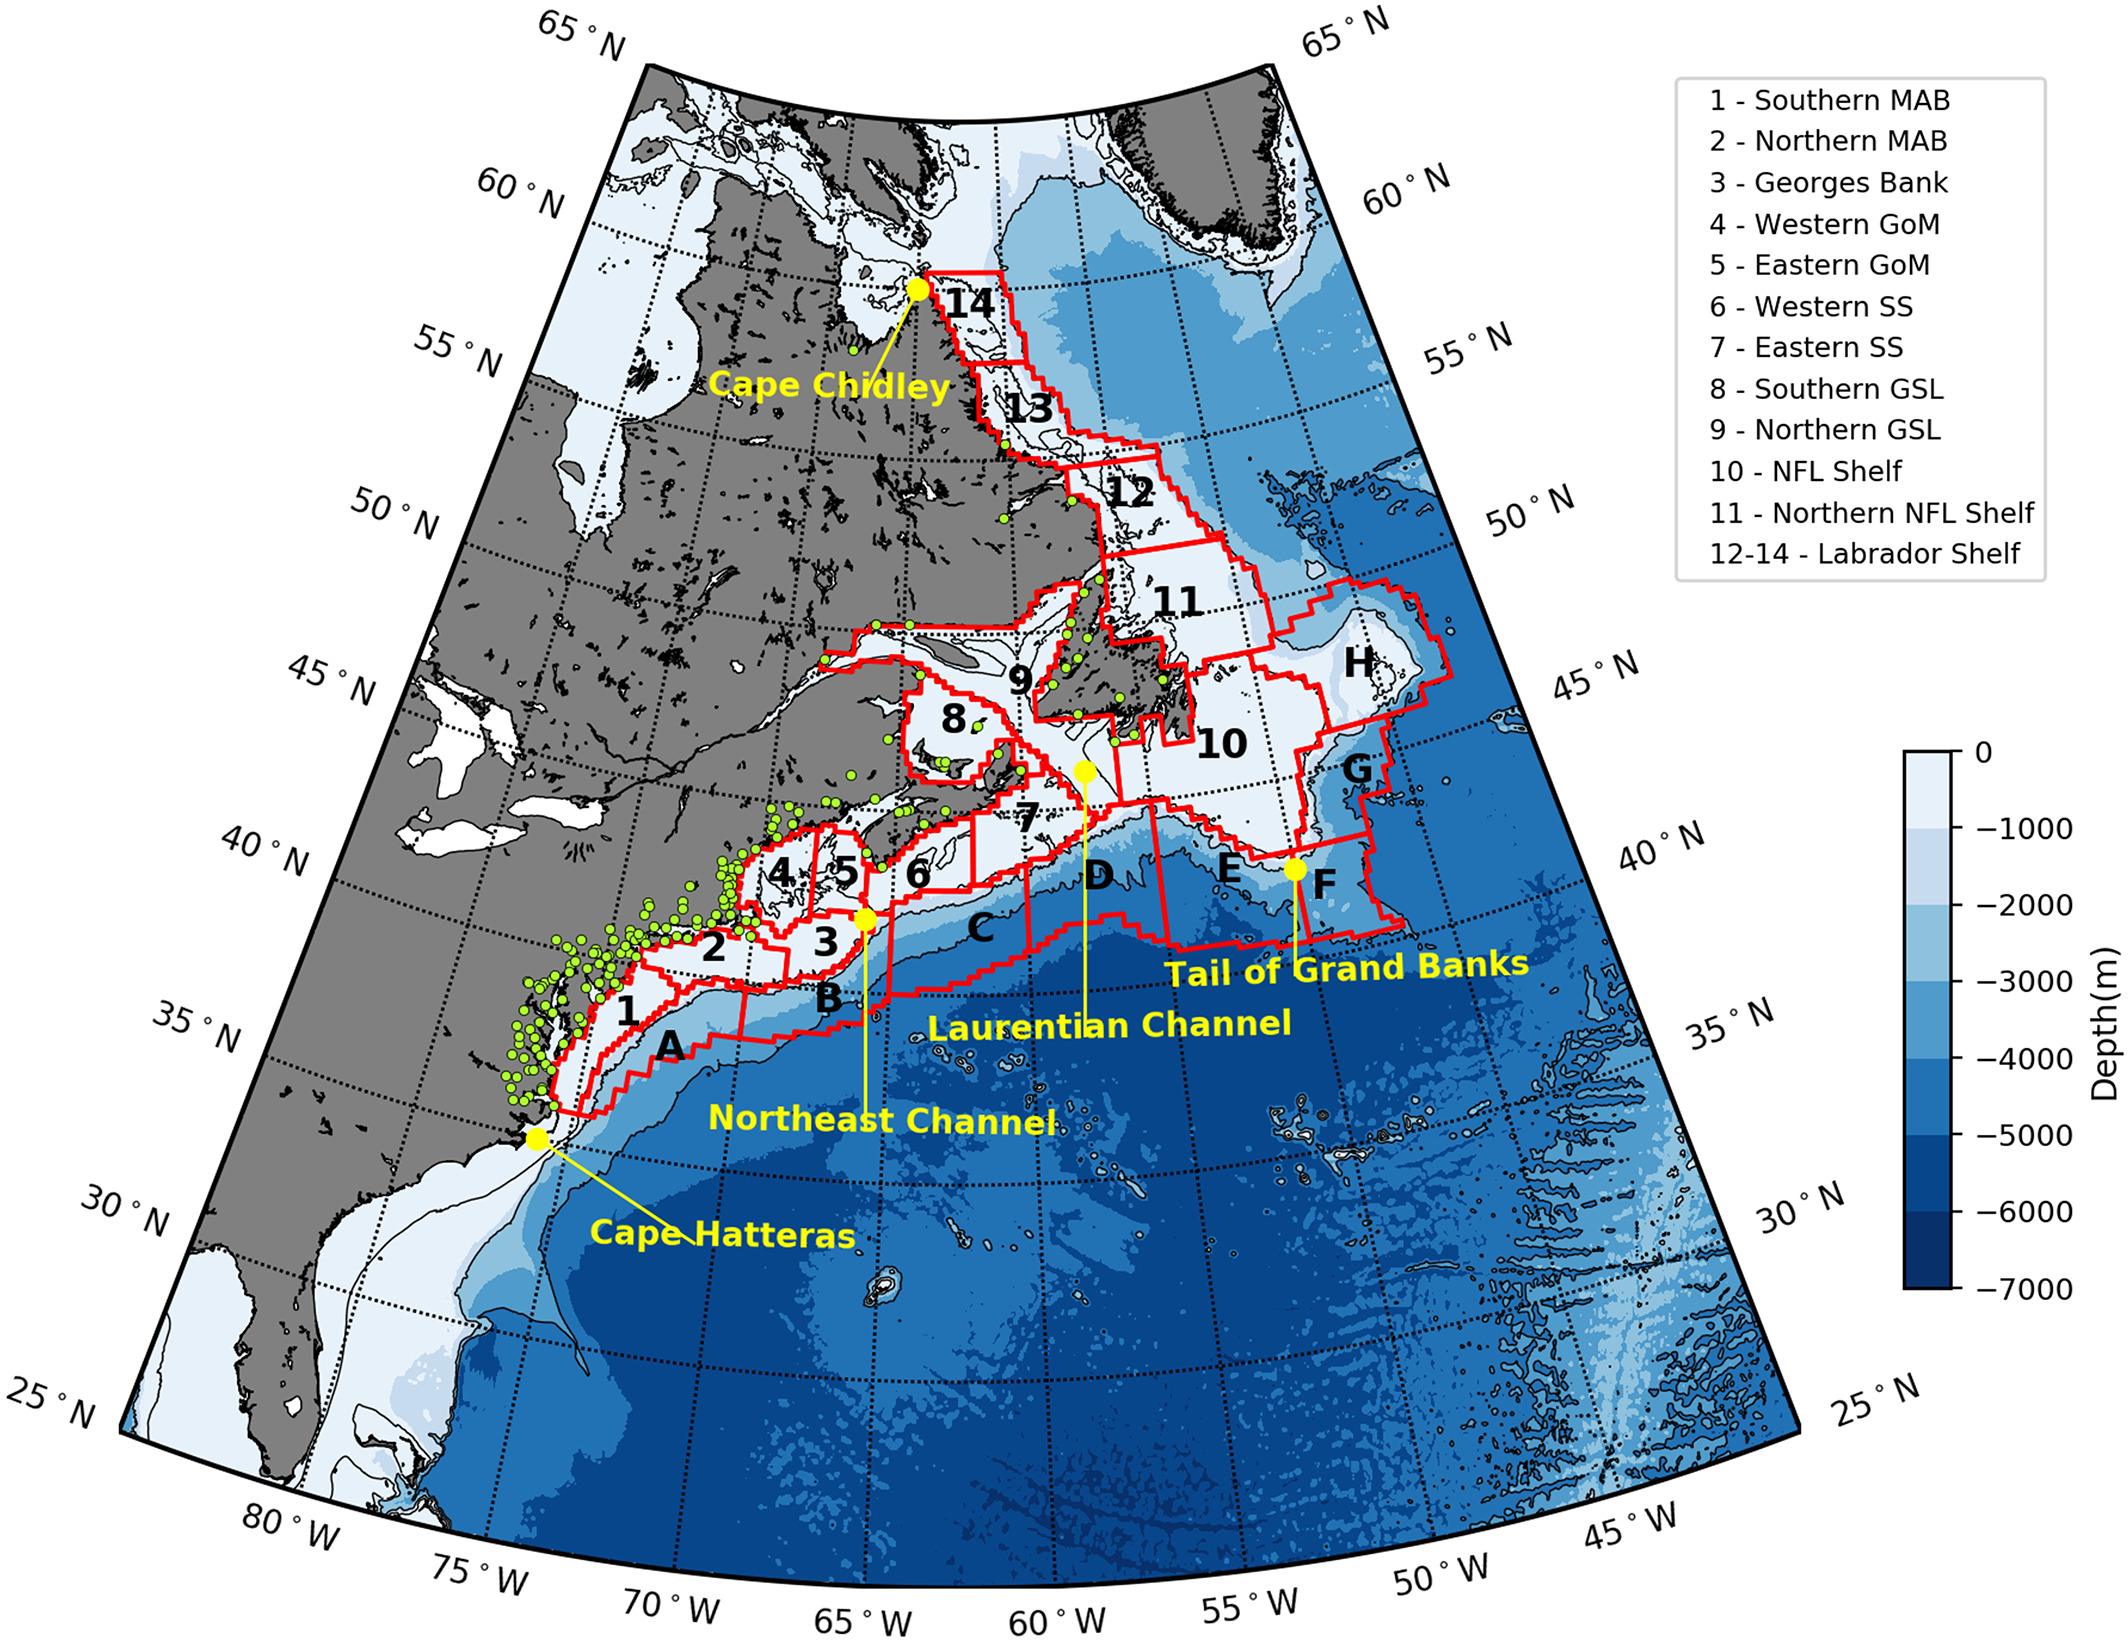

In [4]:
from IPython.display import Image
Image(filename = "/home/sryan/Python/ORCA/NW_Atlantic/projects/ecoboxes_Chen_et_al_2020.jpg", width = 500)

# Detect MHWs for specific box or group of boxes

In [5]:
# specifiy which boxes you want to use for detection (chose from mask_names)

def whichbox(boxes):
    """
    INPUT:  boxes='shelf' (average over all shelf boxes)
            boxes='slope' (average over all slope boxes)
            boxes=list of boxes (list of names of boxes that should be used, e.g. ['Southern MAB','Northern MAB','Georges Bank'])
    
    """
    if boxes=='shelf': whichbox = mask_names[:14]
    elif boxes=='slope': whichbox = mask_names[14:]
    else: whichbox = boxes
    
    return whichbox
    
#####################################
# which boxes to use
boxes = ['A','B','C']
# ['Southern MAB','Northern MAB','Georges Bank','Western GoM',
#              'Eastern GoM','Western SS','Eastern SS','Southern GSL','Northern GSL',
#              'NFL Shelf','Northern NFL Shelf','Labrador Shelf1', 'Labrador Shelf2',
#              'Labrador Shelf3','A','B','C','D','E','F','G','H']
#####################################

# box_mask = xr.zeros_like(mask['Southern MAB'])
# box_mask.rename()
box_mask = np.zeros(mask['Southern MAB'].shape)
for name in whichbox(boxes):
    dummy = mask[name].values
    dummy[np.isnan(dummy)]=0
    box_mask = box_mask+dummy
box_mask[box_mask==0]=np.nan


sst = (oisst['sst'].transpose('time','lon','lat')*box_mask).mean(('lat','lon'))

############### To Do ###################
# 1) plot map with selected boxes

## Marine Heatwave Detection

The marineHeatWaves (`mhw`) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (`detect`) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs. We first run the MHW detection algorithm which returns the variable `mhws`, consisting of the detected MHWs, and `clim`, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:


In [6]:
# have to convert time for input
time = mdates.date2num(oisst['time'].values).astype(int) # datenum
dates=oisst.time.values  # datetime

###################################################
# RUN CODE
mhws, clim = mhw.detect(time, sst.values)
###################################################

# how many events
print('Number of events detected: ' , mhws['n_events'])

 # find largest event
ev = np.argmax(mhws['intensity_max'])
print('\n**Largest Event**\n\nMaximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print('Duration:', mhws['duration'][ev], 'days')
print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

# convert output to pandas dataframe and to xarray
pd_mhw = pd.DataFrame(mhws)
xr_mhw = pd_mhw.to_xarray()
pd_clim = pd.DataFrame(clim)
xr_clim = pd_clim.to_xarray()
xr_clim['index']=oisst.time.values
xr_clim=xr_clim.rename({'index':'time'})

pd.set_option('display.max_rows', None)
pd_mhw[['date_start','date_end','date_peak','duration','category','intensity_max_abs','intensity_mean_abs']]

Number of events detected:  45

**Largest Event**

Maximum intensity: 3.9045431970967073 deg. C
Average intensity: 2.536997044318742 deg. C
Cumulative intensity: 530.2323822626171 deg. C-days
Duration: 209 days
Start date: 29 November 2014
End date: 25 June 2015


,date_start,date_end,date_peak,duration,category,intensity_max_abs,intensity_mean_abs
0,1994-06-13,1994-08-05,1994-07-10,54,Moderate,23.302075,22.474221
1,1999-06-13,1999-06-18,1999-06-14,6,Moderate,19.668587,19.722170
2,2000-03-23,2000-03-30,2000-03-28,8,Moderate,12.993863,12.841319
3,2003-09-27,2003-10-02,2003-09-29,6,Moderate,23.190419,23.072553
4,2005-10-07,2005-10-15,2005-10-09,9,Moderate,22.683421,22.260873
5,2009-11-19,2009-12-11,2009-11-27,23,Moderate,18.410198,17.546340
6,2010-07-05,2010-07-22,2010-07-08,18,Moderate,23.234944,23.192124
7,2011-05-27,2011-06-03,2011-05-30,8,Moderate,18.418101,18.151824
8,2012-04-20,2012-04-26,2012-04-22,7,Moderate,14.271699,14.029984
9,2012-05-24,2012-06-04,2012-05-31,12,Moderate,18.401412,18.013710


# Check out largest event

/home/sryan/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, "['A', 'B', 'C']")

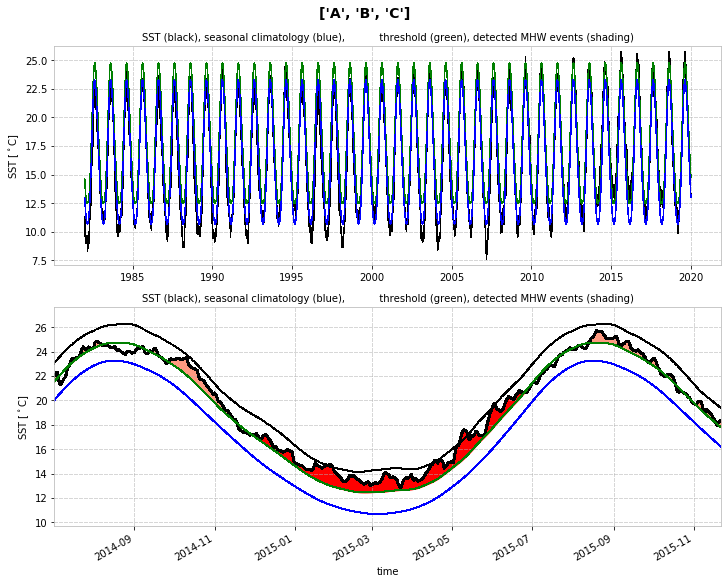

In [7]:
thresh = xr_clim['thresh']-xr_clim['seas']
period = [str(xr_mhw['date_start'][ev-10].values),str(xr_mhw['date_start'][ev+10].values)]

fig,ax = plt.subplots(figsize=(10,8),nrows=2,constrained_layout=True)
                     
# Plot SST, seasonal cycle, and threshold
ax[0].plot(dates, sst, 'k-')
ax[0].plot(dates, clim['thresh'], 'g-')
ax[0].plot(dates, clim['seas'], 'b-')
ax[0].set_title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
# plt.xlim(time[0], time[-1])
ax[0].set_ylim(sst.min()-0.5, sst.max()+0.5)
ax[0].set_ylabel(r'SST [$^\circ$C]')


# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(time==mhws['time_start'][ev0])[0][0]
    t2 = np.where(time==mhws['time_end'][ev0])[0][0]
    ax[1].fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(time==mhws['time_start'][ev])[0][0]
t2 = np.where(time==mhws['time_end'][ev])[0][0]
ax[1].fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
ax[1].plot(dates, sst, 'k-', linewidth=2)
ax[1].plot(dates, clim['thresh'], 'g-', linewidth=1)
ax[1].plot(dates, clim['seas'], 'b-', linewidth=1)
(xr_clim['thresh']+thresh).sel(time=slice(*period)).plot(ax=ax[1],color='k',linestyle='dashed',linewidth=0.5,
                                                        label='climatology*2')
ax[1].set_title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
ax[1].set_xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
ax[1].set_ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
ax[1].set_ylabel(r'SST [$^\circ$C]')

fig.suptitle(boxes,fontweight='bold',fontsize=14)

# Check out a specific year

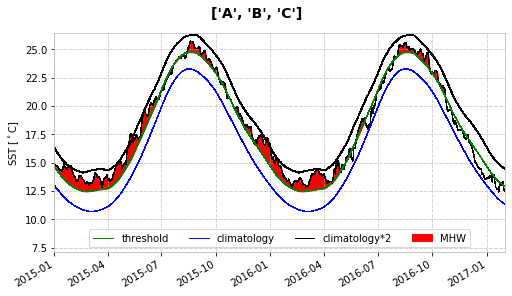

In [19]:
###############################################
# which period to you want to focus on
period = ['2015-01-01','2017-02-01']
###############################################
from datetime import datetime

datenum_start = mdates.date2num(datetime.strptime(period[0], "%Y-%m-%d"))
datenum_end = mdates.date2num(datetime.strptime(period[1], "%Y-%m-%d"))


fig,ax = plt.subplots(figsize=(7,4),constrained_layout=True)
                     
# Plot SST, seasonal cycle, and threshold
sst.sel(time=slice(*period)).plot(ax=ax,color='k')
xr_clim['thresh'].sel(time=slice(*period)).plot(ax=ax,color='g',label='threshold')
xr_clim['seas'].sel(time=slice(*period)).plot(ax=ax,color='b',label='climatology')
(xr_clim['thresh']+thresh).sel(time=slice(*period)).plot(ax=ax,color='k',linestyle='dashed',linewidth=0.5,
                                                        label='climatology*2')

mhws_period = xr_mhw.where((xr_mhw.time_end>=datenum_start) & (xr_mhw.time_start<=datenum_end),drop=True)
for ev0 in mhws_period.index.values:
    t1 = np.where(time==mhws['time_start'][ev0])[0][0]
    t2 = np.where(time==mhws['time_end'][ev0])[0][0]
#     ax.fill_between(dates[t1:t2+1], clim['thresh'][t1:t2+1], (clim['thresh'][t1:t2+1]+thresh[t1:t2+1].values), \
#                      color='r')
    ax.fill_between(dates[t1:t2+1], sst[t1:t2+1], (clim['thresh'][t1:t2+1]), \
                     color='r')
# for legend only
# ax.fill_between(dates[t1:t2+1], sst[t1:t2+1], (clim['thresh'][t1:t2+1]+thresh[t1:t2+1].values), \
#                      color='darkred')
ax.fill_between(dates[t1:t2+1], sst[t1:t2+1], (clim['thresh'][t1:t2+1]), \
                     color='r',label='MHW')

ax.set_xlim(period)
ax.set_ylim(sst.min()-0.5, sst.max()+0.7)
ax.set_ylabel(r'SST [$^\circ$C]')
ax.set_xlabel('')

ax.legend(ncol=4,loc='lower center')

fig.suptitle(boxes,fontweight='bold',fontsize=14);

# plt.savefig('/climodes/data4/sryan/plots_MHWcode_NWA/mhw_detect_boxes_ABC_2012.png',dpi=300,bbox_inches='tight')

# Statistics
## Bar charts over event number

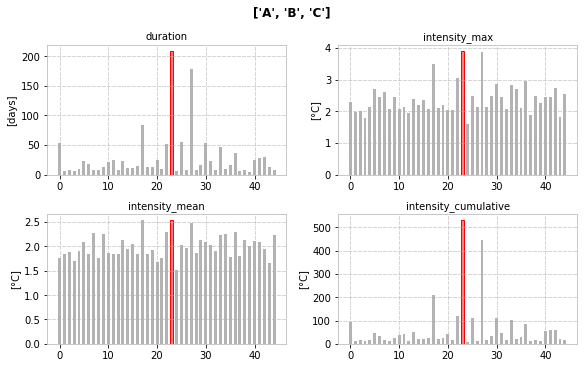

In [9]:
plt.close("all")
fig,ax = plt.subplots(figsize=(8,5),nrows=2,ncols=2,constrained_layout=True)

for axh,var,ylabel in zip(ax.flat,['duration','intensity_max','intensity_mean','intensity_cumulative'],
                         ['[days]','[\N{DEGREE SIGN}C]','[\N{DEGREE SIGN}C]','[\N{DEGREE SIGN}C]']):
    evMax = np.argmax(mhws[var])
    axh.bar(range(mhws['n_events']), xr_mhw[var], width=0.6, \
            color=(0.7,0.7,0.7))
    axh.bar(evMax, xr_mhw[var].isel(index=evMax), width=0.6, \
            color=(1,0.5,0.5))
    axh.bar(ev, xr_mhw[var].isel(index=ev), width=0.6, edgecolor=(1,0.,0.),color='none')
    axh.set_title(var)
    axh.set_ylabel(ylabel)
fig.suptitle(boxes,fontweight='bold');

## Bar chart over time 

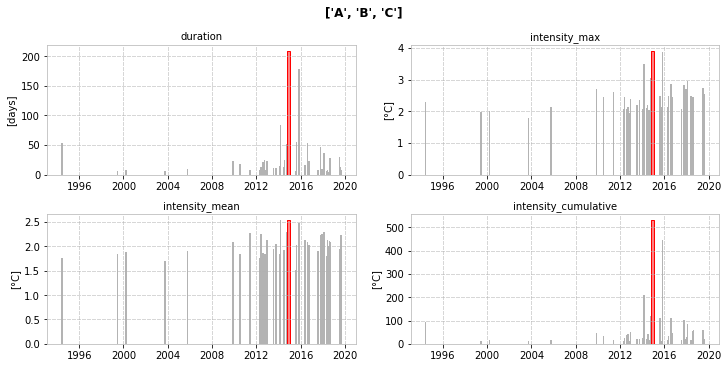

In [10]:
plt.close("all")
fig,ax = plt.subplots(figsize=(10,5),nrows=2,ncols=2,constrained_layout=True)

for axh,var,ylabel in zip(ax.flat,['duration','intensity_max','intensity_mean','intensity_cumulative'],
                         ['[days]','[\N{DEGREE SIGN}C]','[\N{DEGREE SIGN}C]','[\N{DEGREE SIGN}C]']):
    evMax = np.argmax(mhws[var])
    axh.bar(xr_mhw.date_start.values, xr_mhw[var], width=50,color=(0.7,0.7,0.7))
    axh.bar(str(xr_mhw['date_start'][evMax].values), xr_mhw[var].isel(index=evMax), width=100, \
            color=(1,0.5,0.5))
    axh.bar(str(xr_mhw['date_start'][ev].values), xr_mhw[var].isel(index=ev), width=100, edgecolor=(1,0.,0.),color='none')
    axh.set_title(var)
    axh.set_ylabel(ylabel)
fig.suptitle(boxes,fontweight='bold');

The red shaded bars show the largest event on record by duration, maximum intensity, cumulative intensity, and mean intensity, while the red-outlined bars show the specific event chosen above (which happens to be largest by maximum intensity). We can see how this event ranks according to the other metrics as follows:

In [11]:
rank, returnPeriod = mhw.rank(time, mhws)
print("The picked largest event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print("The picked largest is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print("The picked largest event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print("The picked largest event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The picked largest event is ranked number 1 by duration
The picked largest is ranked number 1 by maximum intensity
The picked largest event is ranked number 1 by mean intensity
The picked largest event is ranked number 1 by cumulative intensity


We can even look at the return periods for events with those properties:

In [12]:
print("The return period for an event with this duration was " \
        + str(returnPeriod['duration'][ev]) + " years")
print("The return period for an event with this maximum intensity was " \
        + str(returnPeriod['intensity_max'][ev]) + " years")
print("The return period for an event with this mean intensity was " \
        + str(returnPeriod['intensity_mean'][ev]) + " years")
print("The return period for an event with this cumulative intensity was " \
        + str(returnPeriod['intensity_cumulative'][ev]) + " years")

The return period for an event with this duration was 38.998631074606436 years
The return period for an event with this maximum intensity was 38.998631074606436 years
The return period for an event with this mean intensity was 38.998631074606436 years
The return period for an event with this cumulative intensity was 38.998631074606436 years


# Block-averaged Marine Heatwave properties

The marineHeatWaves (`mhw`) module also consists of functions to calculate the average of MHW properties over blocks in time (e.g., annually, decadally). The block-averaging function (`blockAverage`) takes as input a set of detected MHWs (i.e., the output from `detect`, the detection function described above) and outputs the MHW properties averaged over the specified block-length. This output can then be passed through the `meanTrend` function in order to calculate the time-mean and linear trend of the MHW properties over the measurement period.

Let's start by applying the block-averaging function to the Mediterranean MHWs which are stored in the variable `mhws`, using the default block length of 1 year (i.e., annual averages):

In [13]:
mhwBlock = mhw.blockAverage(time, mhws)

The variable `mhwBlock` has a set of keys which are time series of the MHW properties over the blocks. The central year of the blocks are stored in the key `years_centre` so we can look at, as an example, time series of MHW counts in each year and the average maximum intensity in each year:


Text(0.5, 1.0, 'Average MHW maximum intensity by year')

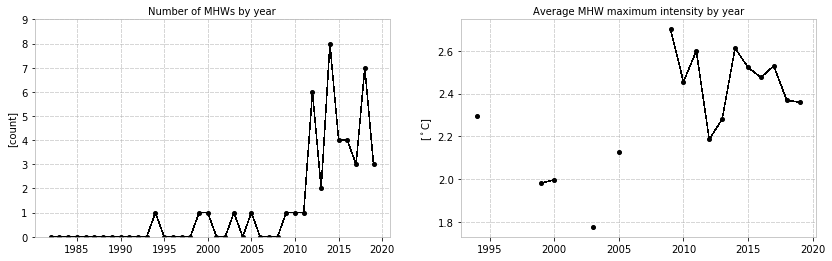

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(mhwBlock['years_centre'], mhwBlock['count'], 'k-o')
plt.ylim(0,9)
plt.ylabel('[count]')
plt.title('Number of MHWs by year')
plt.subplot(1,2,2)
plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_max'], 'k-o')
plt.ylabel(r'[$^\circ$C]')
plt.title('Average MHW maximum intensity by year')

We can calculate the mean and trend of the MHW properties using the `meanTrend` function:

In [15]:
mean, trend, dtrend = mhw.meanTrend(mhwBlock)
print("There are on average " + str(mean['count']) + " MHWs in each year, \n \
with a linear trend of " + str(10*trend['count']) + " MHW events per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['count']) > dtrend['count']) + "\n")

print("The average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
with a linear trend of " + str(10*trend['intensity_max']) + " deg. C per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))

There are on average 1.1842105263157898 MHWs in each year, 
 with a linear trend of 1.2616259984681035 MHW events per decade 
 This trend is statistically significant (p<0.05): True

The average maximum intensity is 2.1412422442611474 deg. C, 
 with a linear trend of 0.2040919010665555 deg. C per decade 
 This trend is statistically significant (p<0.05): True
